In [ ]:
import glob
import skimage.io as io
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random as r
import gc; gc.enable() # memory is tight
from tqdm.notebook import tqdm # yaptığımız işlemlerdeki ilerlemeyi göselleştirmeye yarayan bir kütüphane
from os import listdir
from os.path import isfile, join
import os
import tensorflow as tf

``plugin =simpleitk`` tıbbı, ct, mr gibi görüntüleri incelemek için özel olarak hazırlanmış 

In [ ]:
# glob komutu ile train verilerimizin dosya yolunu files dosyasının içine atıyoruz. 
files = glob.glob("../input/hubmap-5185x256x256-image-and-masks/train"+"/*.png",recursive=True) 

In [ ]:
files[0:5]

In [ ]:
len(files)

In [ ]:
örnek =files[1678]

In [ ]:
img = io.imread(örnek,as_gray=False) # örnek görüntüyü okuyouz.

In [ ]:
img.shape

In [ ]:
plt.imshow(img,cmap='gray')

In [ ]:
örnek

In [ ]:
img_seg =io.imread('../input/hubmap-5185x256x256-image-and-masks/masks/0486052bb_85.png')

In [ ]:
plt.imshow(img_seg)

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
plt.title('a) ham görüntü')
plt.axis('off')
plt.imshow(img,cmap='gray')

plt.subplot(1,2,2)
plt.title('b) seg görüntü')
plt.axis('off')
plt.imshow(img_seg)

In [ ]:
lab = cv2.cvtColor(img,cv2.COLOR_RGB2LAB)

In [ ]:
l,a,b = cv2.split(lab)

In [ ]:
plt.imshow(l,cmap='gray')

In [ ]:
plt.imshow(a,cmap='gray')

In [ ]:
plt.imshow(b)

In [ ]:
red_img = img[:,:,2]
print(red_img.shape)
plt.imshow(red_img)

In [ ]:
green_img = img[:,:,1]
plt.imshow(green_img)

In [ ]:
blue_img = img[:,:,0]
plt.imshow(blue_img)

# Train image

In [ ]:
directory_path = '../input/hubmap-5185x256x256-image-and-masks/train';
image_paths = [f for f in listdir(directory_path) if isfile(join(directory_path, f))] 
r.seed(9)
r.shuffle(image_paths)

In [ ]:
image_paths[0:5]

In [ ]:
len(image_paths)

In [ ]:
files = os.path.join(directory_path+'/'+image_paths[0])
files

In [ ]:
def train_array():
    img_liste = []
    for i in tqdm(range(len(image_paths[5000:]))) :
        file = os.path.join(directory_path+'/'+image_paths[i])
        img = io.imread(file,as_gray=True) # görüntüleri okuyoruz
        #img = io.imread(file) # görüntüleri okuyoruz
        #img = cv2.resize(img,(512,512))
        #img = img.transpose(2,0,1)
        img = (img-img.mean())/img.std() # standartize ediyoruz
        #img = img[1,:,:]
        img = np.expand_dims(img,axis=0)
        img.astype('float32')
        img_liste.append(img)
    return np.array(img_liste,np.float32)

In [ ]:
train = train_array()

In [ ]:
train.shape

In [ ]:
plt.figure(figsize=(20,12))
a = -1
liste = range(len(train))
for i in r.sample(liste, 12) :
    a+=1
    plt.subplot(3,4,a+1)
    plt.imshow(train[i].reshape(512,512))
    
plt.tight_layout()

# Segment image

In [ ]:
seg_path='../input/hubmap-5185x256x256-image-and-masks/masks'
def seg_array():
    img_liste = []
    for i in tqdm(range(len(image_paths[5000:]))) :
        #name=image_paths[i].split('_')
        file = os.path.join(seg_path+'/'+image_paths[i])
        #file = os.path.join(seg_path+'/'+name[0]+'_mask_'+name[1]+'_'+name[2])
        img = io.imread(file) # görüntüleri okuyoruz
        #img = cv2.resize(img,(512,512))
        img.astype('float32')
        img = np.expand_dims(img,axis=0)
        img_liste.append(img)

    return np.array(img_liste,np.float32)

In [ ]:
seg = seg_array()

In [ ]:
seg.shape

# Visualization

In [ ]:
x=756

plt.figure(figsize=(15,10))

plt.subplot(2,4,1)
plt.imshow(train[x].reshape(512,512),cmap='gray')
plt.title("train image")

plt.subplot(2,4,2)
plt.imshow(seg[x].reshape(512,512))
plt.title("mask")

x=1293

plt.subplot(2,4,3)
plt.imshow(train[x].reshape(512,512),cmap='gray')
plt.title("train image")

plt.subplot(2,4,4)
plt.imshow(seg[x].reshape(512,512))
plt.title("mask")

x =273

plt.subplot(2,4,5)
plt.imshow(train[x].reshape(512,512),cmap='gray')
plt.title("train image")

plt.subplot(2,4,6)
plt.imshow(seg[x].reshape(512,512))
plt.title("mask")

x = 87

plt.subplot(2,4,7)
plt.imshow(train[x].reshape(512,512),cmap='gray')
plt.title("train image")

plt.subplot(2,4,8)
plt.imshow(seg[x].reshape(512,512))
plt.title("mask")
plt.show()

# MODEL Unet
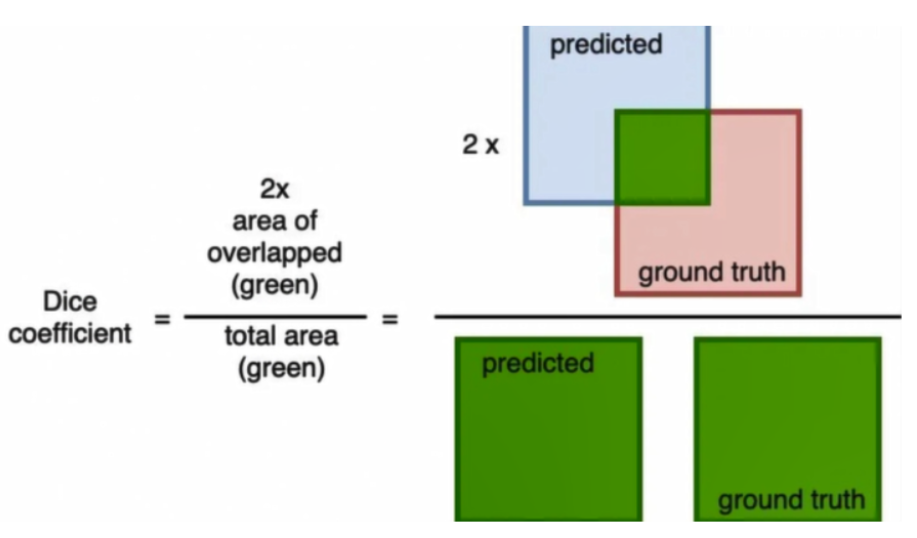

In [ ]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, merge, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

K.set_image_data_format('channels_first')


def dice_coef(y_true, y_pred):
    smooth = 0.005 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    
def unet_model(pretrained_weights=None):
    
    inputs = Input((1, 512 , 512))
    
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)
    
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization(axis=1)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2)) (batch4)
    
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (batch5)
    up6 = concatenate([up6, conv4], axis=1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (up6)
    batch6 = BatchNormalization(axis=1)(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization(axis=1)(conv6)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch6)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [ ]:
model = unet_model()

# Train

In [ ]:
history = model.fit(train,
          seg,
          validation_split=0.20,
          batch_size=8,
          epochs=1,
          verbose=1)

In [ ]:
model.save_weights("HubMap_weight_vs16.h5")

In [ ]:
model.save("HubMap_model_vs16.h5")

In [ ]:
score = model.evaluate(x=train,y=seg,batch_size=32)
score
print('Score Accuracy : {:.2f}%'.format(score[1]*100))

In [ ]:
print(history.history.keys())

# Accuracy graph

In [ ]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.legend(['Eğitim','Doğrulama'])
plt.title('Doğruluk(Accuracy)%')
plt.xlabel('Epoch Sayısı')
plt.ylabel('Yüzde(%)')

# Loss graph

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Eğitim','Doğrulama'])
plt.title('Kayıp Skoru(Loss)%')
plt.xlabel('Epoch Sayısı')
plt.ylabel('Yüzde(%)')

# Predict (eğitime katılmış görüntüler)

In [ ]:
from keras.models import load_model
model = load_model("../input/hubmap-weight/HubMap_model.h5", compile=False)

In [ ]:
x = 1293
örnek = train[x]
örnek = np.expand_dims(train[x],axis=0)
print(örnek.shape)
pred = model.predict(örnek)


plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.imshow(train[x].reshape(512,512),cmap='gray')
plt.title("Original image")

plt.subplot(2,3,2)
plt.imshow(seg[x].reshape(512,512))
plt.title("Doctor's segmentation")

plt.subplot(2,3,3)
plt.imshow(pred.reshape(512,512))
plt.title("Model's predict segmentation")

plt.subplot(234)
plt.imshow(train[x].reshape(512,512))
plt.subplot(235)
plt.imshow(train[x].reshape(512,512).squeeze(), cmap="Greys")
plt.imshow(seg[x].reshape(512,512).squeeze(), alpha=0.5, cmap="Greens")
plt.subplot(236)
plt.imshow(train[x].reshape(512,512), cmap="Greys")
plt.imshow(pred.reshape(512,512).squeeze(), alpha=0.5, cmap="OrRd")
plt.tight_layout()
plt.show()

In [ ]:
x = 273
örnek = train[x]
örnek = np.expand_dims(train[x],axis=0)
print(örnek.shape)
pred = model.predict(örnek)


plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.imshow(train[x].reshape(512,512),cmap='gray')
plt.title("Original image")

plt.subplot(2,3,2)
plt.imshow(seg[x].reshape(512,512))
plt.title("Doctor's segmentation")

plt.subplot(2,3,3)
plt.imshow(pred.reshape(512,512))
plt.title("Model's predict segmentation")

plt.subplot(234)
plt.imshow(train[x].reshape(512,512))
plt.subplot(235)
plt.imshow(train[x].reshape(512,512).squeeze(), cmap="Greys")
plt.imshow(seg[x].reshape(512,512).squeeze(), alpha=0.5, cmap="Greens")
plt.subplot(236)
plt.imshow(train[x].reshape(512,512), cmap="Greys")
plt.imshow(pred.reshape(512,512).squeeze(), alpha=0.5, cmap="OrRd")
plt.tight_layout()
plt.show()

In [ ]:
x =1278
örnek = train[x]
örnek = np.expand_dims(train[x],axis=0)
print(örnek.shape)
pred = model.predict(örnek)


plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.imshow(train[x].reshape(512,512),cmap='gray')
plt.title("Original image")

plt.subplot(2,3,2)
plt.imshow(seg[x].reshape(512,512))
plt.title("Doctor's segmentation")

plt.subplot(2,3,3)
plt.imshow(pred.reshape(512,512))
plt.title("Model's predict segmentation")

plt.subplot(234)
plt.imshow(train[x].reshape(512,512))
plt.subplot(235)
plt.imshow(train[x].reshape(512,512).squeeze(), cmap="Greys")
plt.imshow(seg[x].reshape(512,512).squeeze(), alpha=0.5, cmap="Greens")
plt.subplot(236)
plt.imshow(train[x].reshape(512,512), cmap="Greys")
plt.imshow(pred.reshape(512,512).squeeze(), alpha=0.5, cmap="OrRd")
plt.tight_layout()
plt.show()

# Predict Test image (eğitime katılmamış görüntülerdir)

In [ ]:
def test_array(file):
    img = io.imread(file,as_gray=False) # görüntüleri okuyoruz
    #img = cv2.resize(img,(256,256))
    #img = img.transpose(2,0,1)
    
    #img = img[1,:,:]
    
    img.astype('float32')
    return img

def test_seg_array(file):
    img = io.imread(file) # görüntüleri okuyoruz
    #img = cv2.resize(img,(256,256))
    img.astype('float32')
    img = np.expand_dims(img,axis=0)
    return img

In [ ]:
test = test_array('../input/hubmap-512x512/train/0486052bb_100.png')
test_seg = test_seg_array("../input/hubmap-512x512/masks/0486052bb_100.png")

#örnek = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)

#örnek = test.copy()

#img = np.expand_dims(örnek,axis=0)
örnek = test/255 # standartize ediyoruz

örnek = np.expand_dims(örnek,axis=0)

pred = model.predict(örnek)


plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.imshow(test)
plt.title("Original image")

plt.subplot(2,3,2)
plt.imshow(test_seg.reshape(512,512))
plt.title("Doctor's segmentation")

plt.subplot(2,3,3)
plt.imshow(pred.reshape(512,512))
plt.title("Model's predict segmentation")

plt.subplot(234)
plt.imshow(test)
plt.subplot(235)
plt.imshow(test.squeeze(), cmap="Greys")
plt.imshow(test_seg.reshape(512,512).squeeze(), alpha=0.5, cmap="Greens")
plt.subplot(236)
plt.imshow(test, cmap="Greys")
plt.imshow(pred.reshape(512,512).squeeze(), alpha=0.5, cmap="OrRd")
plt.tight_layout()
plt.show()


In [ ]:
test = test_array('../input/hubmap-512x512/train/0486052bb_129.png')
test_seg = test_seg_array("../input/hubmap-512x512/masks/0486052bb_129.png")

#örnek = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)

#örnek = test.copy()

#img = np.expand_dims(örnek,axis=0)
örnek = test/255 # standartize ediyoruz

örnek = np.expand_dims(örnek,axis=0)

pred = model.predict(örnek)


plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.imshow(test)
plt.title("Original image")

plt.subplot(2,3,2)
plt.imshow(test_seg.reshape(512,512))
plt.title("Doctor's segmentation")

plt.subplot(2,3,3)
plt.imshow(pred.reshape(512,512))
plt.title("Model's predict segmentation")

plt.subplot(234)
plt.imshow(test)
plt.subplot(235)
plt.imshow(test.squeeze(), cmap="Greys")
plt.imshow(test_seg.reshape(512,512).squeeze(), alpha=0.5, cmap="Greens")
plt.subplot(236)
plt.imshow(test, cmap="Greys")
plt.imshow(pred.reshape(512,512).squeeze(), alpha=0.5, cmap="OrRd")
plt.tight_layout()
plt.show()



In [ ]:
test = test_array('../input/hubmap-512x512/train/0486052bb_118.png')
test_seg = test_seg_array("../input/hubmap-512x512/masks/0486052bb_118.png")

#örnek = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)

#örnek = test.copy()

#img = np.expand_dims(örnek,axis=0)
örnek = test/255 # standartize ediyoruz

örnek = np.expand_dims(örnek,axis=0)

pred = model.predict(örnek)


plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.imshow(test)
plt.title("Original image")

plt.subplot(2,3,2)
plt.imshow(test_seg.reshape(512,512))
plt.title("Doctor's segmentation")

plt.subplot(2,3,3)
plt.imshow(pred.reshape(512,512))
plt.title("Model's predict segmentation")

plt.subplot(234)
plt.imshow(test)
plt.subplot(235)
plt.imshow(test.squeeze(), cmap="Greys")
plt.imshow(test_seg.reshape(512,512).squeeze(), alpha=0.5, cmap="Greens")
plt.subplot(236)
plt.imshow(test, cmap="Greys")
plt.imshow(pred.reshape(512,512).squeeze(), alpha=0.5, cmap="OrRd")
plt.tight_layout()
plt.show()



In [ ]:
test = test_array('../input/hubmap-512x512/train/0486052bb_203.png')
test_seg = test_seg_array("../input/hubmap-512x512/masks/0486052bb_203.png")

#örnek = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)

#örnek = test.copy()

#img = np.expand_dims(örnek,axis=0)
örnek = test/255 # standartize ediyoruz

örnek = np.expand_dims(örnek,axis=0)

pred = model.predict(örnek)


plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.imshow(test)
plt.title("Original image")

plt.subplot(2,3,2)
plt.imshow(test_seg.reshape(512,512))
plt.title("Doctor's segmentation")

plt.subplot(2,3,3)
plt.imshow(pred.reshape(512,512))
plt.title("Model's predict segmentation")

plt.subplot(234)
plt.imshow(test)
plt.subplot(235)
plt.imshow(test.squeeze(), cmap="Greys")
plt.imshow(test_seg.reshape(512,512).squeeze(), alpha=0.5, cmap="Greens")
plt.subplot(236)
plt.imshow(test, cmap="Greys")
plt.imshow(pred.reshape(512,512).squeeze(), alpha=0.5, cmap="OrRd")
plt.tight_layout()
plt.show()


In [ ]:
test = test_array('../input/hubmap-512x512/train/0486052bb_569.png')
test_seg = test_seg_array("../input/hubmap-512x512/masks/0486052bb_569.png")

#örnek = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)

#örnek = test.copy()

#img = np.expand_dims(örnek,axis=0)
örnek = test/255 # standartize ediyoruz

örnek = np.expand_dims(örnek,axis=0)

pred = model.predict(örnek)


plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.imshow(test)
plt.title("Original image")

plt.subplot(2,3,2)
plt.imshow(test_seg.reshape(512,512))
plt.title("Doctor's segmentation")

plt.subplot(2,3,3)
plt.imshow(pred.reshape(512,512))
plt.title("Model's predict segmentation")

plt.subplot(234)
plt.imshow(test)
plt.subplot(235)
plt.imshow(test.squeeze(), cmap="Greys")
plt.imshow(test_seg.reshape(512,512).squeeze(), alpha=0.5, cmap="Greens")
plt.subplot(236)
plt.imshow(test, cmap="Greys")
plt.imshow(pred.reshape(512,512).squeeze(), alpha=0.5, cmap="OrRd")
plt.tight_layout()
plt.show()



In [ ]:
test = test_array('../input/hubmap-512x512/train/0486052bb_711.png')
test_seg = test_seg_array("../input/hubmap-512x512/masks/0486052bb_711.png")

#örnek = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)

#örnek = test.copy()

#img = np.expand_dims(örnek,axis=0)
örnek = test/255 # standartize ediyoruz

örnek = np.expand_dims(örnek,axis=0)

pred = model.predict(örnek)


plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.imshow(test)
plt.title("Original image")

plt.subplot(2,3,2)
plt.imshow(test_seg.reshape(512,512))
plt.title("Doctor's segmentation")

plt.subplot(2,3,3)
plt.imshow(pred.reshape(512,512))
plt.title("Model's predict segmentation")

plt.subplot(234)
plt.imshow(test)
plt.subplot(235)
plt.imshow(test.squeeze(), cmap="Greys")
plt.imshow(test_seg.reshape(512,512).squeeze(), alpha=0.5, cmap="Greens")
plt.subplot(236)
plt.imshow(test, cmap="Greys")
plt.imshow(pred.reshape(512,512).squeeze(), alpha=0.5, cmap="OrRd")
plt.tight_layout()
plt.show()


In [ ]:
test = test_array('../input/hubmap-512x512/train/095bf7a1f_1073.png')
test_seg = test_seg_array("../input/hubmap-512x512/masks/095bf7a1f_1073.png")

#örnek = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)

#örnek = test.copy()

#img = np.expand_dims(örnek,axis=0)
örnek = test/255 # standartize ediyoruz

örnek = np.expand_dims(örnek,axis=0)

pred = model.predict(örnek)


plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.imshow(test)
plt.title("Original image")

plt.subplot(2,3,2)
plt.imshow(test_seg.reshape(512,512))
plt.title("Doctor's segmentation")

plt.subplot(2,3,3)
plt.imshow(pred.reshape(512,512))
plt.title("Model's predict segmentation")

plt.subplot(234)
plt.imshow(test)
plt.subplot(235)
plt.imshow(test.squeeze(), cmap="Greys")
plt.imshow(test_seg.reshape(512,512).squeeze(), alpha=0.5, cmap="Greens")
plt.subplot(236)
plt.imshow(test, cmap="Greys")
plt.imshow(pred.reshape(512,512).squeeze(), alpha=0.5, cmap="OrRd")
plt.tight_layout()
plt.show()



In [ ]:
test = test_array('../input/hubmap-512x512/train/095bf7a1f_1191.png')
test_seg = test_seg_array("../input/hubmap-512x512/masks/095bf7a1f_1191.png")

#örnek = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)

#örnek = test.copy()

#img = np.expand_dims(örnek,axis=0)
örnek = test/255 # standartize ediyoruz

örnek = np.expand_dims(örnek,axis=0)

pred = model.predict(örnek)


plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.imshow(test)
plt.title("Original image")

plt.subplot(2,3,2)
plt.imshow(test_seg.reshape(512,512))
plt.title("Doctor's segmentation")

plt.subplot(2,3,3)
plt.imshow(pred.reshape(512,512))
plt.title("Model's predict segmentation")

plt.subplot(234)
plt.imshow(test)
plt.subplot(235)
plt.imshow(test.squeeze(), cmap="Greys")
plt.imshow(test_seg.reshape(512,512).squeeze(), alpha=0.5, cmap="Greens")
plt.subplot(236)
plt.imshow(test, cmap="Greys")
plt.imshow(pred.reshape(512,512).squeeze(), alpha=0.5, cmap="OrRd")
plt.tight_layout()
plt.show()


In [ ]:
test = test_array('../input/hubmap-512x512/train/0486052bb_127.png')
test_seg = test_seg_array("../input/hubmap-512x512/masks/0486052bb_127.png")

#örnek = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)

#örnek = test.copy()

#img = np.expand_dims(örnek,axis=0)
örnek = test/255 # standartize ediyoruz

örnek = np.expand_dims(örnek,axis=0)

pred = model.predict(örnek)


plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.imshow(test)
plt.title("Original image")

plt.subplot(2,3,2)
plt.imshow(test_seg.reshape(512,512))
plt.title("Doctor's segmentation")

plt.subplot(2,3,3)
plt.imshow(pred.reshape(512,512))
plt.title("Model's predict segmentation")

plt.subplot(234)
plt.imshow(test)
plt.subplot(235)
plt.imshow(test.squeeze(), cmap="Greys")
plt.imshow(test_seg.reshape(512,512).squeeze(), alpha=0.5, cmap="Greens")
plt.subplot(236)
plt.imshow(test, cmap="Greys")
plt.imshow(pred.reshape(512,512).squeeze(), alpha=0.5, cmap="OrRd")
plt.tight_layout()
plt.show()


# Submit

In [ ]:
import pandas as pd
local_file = '../input/shift-sub/submission.csv'

df_submit = pd.read_csv('../input/hubmap-kidney-segmentation/sample_submission.csv', index_col='id')
df_local  = pd.read_csv(local_file, index_col='id')

df_submit.loc[df_local.index.values] = df_local.values  
df_submit.to_csv('submission.csv')
print(df_submit)
print('sucessful!')